I'm not particularly happy that I have to analyse rape and murder statistics as part of my course :/

This is absolutely not okay for sexual assault victims. 

I hope these datasets have been changed. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from pca import pca

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from sklearn.metrics import accuracy_score, silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

# load dataset

df = pd.read_csv("UsArrests.csv")
df.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
# check features of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [4]:
# change column types to float

df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.dtypes

City         object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [5]:
# check for missing values

count = df.isna().sum()
print(count)

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


In [6]:
# rename city column to state

df.rename(columns = {'City':'State'}, inplace = True)

# set state column as index

df.set_index(df['State'])

df.head()


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236.0,58.0,21.2
1,Alaska,10.0,263.0,48.0,44.5
2,Arizona,8.1,294.0,80.0,31.0
3,Arkansas,8.8,190.0,50.0,19.5
4,California,9.0,276.0,91.0,40.6


In [7]:
# check feature statistics

df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Text(0.5, 1.0, 'Correlation heat map of US arrests')

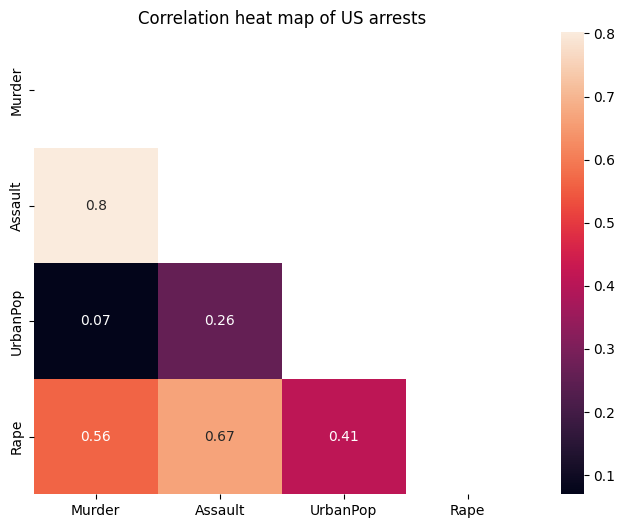

In [8]:
# look at how data features correlates with each other by plotting heatmap

plt.figure(figsize=(8,6))
arrest_corr = df.corr()

dropmirror = np.zeros_like(arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True

sns.heatmap(arrest_corr, annot = True, mask = dropmirror)
plt.title('Correlation heat map of US arrests')


Assault and murder correlate highly with rape.
Assault correlates highly with murder. 

I don't know if this data set reflects single or mulitple incidents e.g., if someone commits assault and rape at the same time, are they charged with both? 

Whilst this would not affect murder (if someone is arrested for murder, it probably is irrelevant that they also commited result) but may affect the statistics for sexual violence crimes. 

I also do not know if this dataset reflects criminal charges, but or just arrests. Being arrested for a crime does not mean that a) the crime was committed or b) that the person was found guilty of it. 

Text(0.5, 1.0, 'Data distribution of three types of crime')

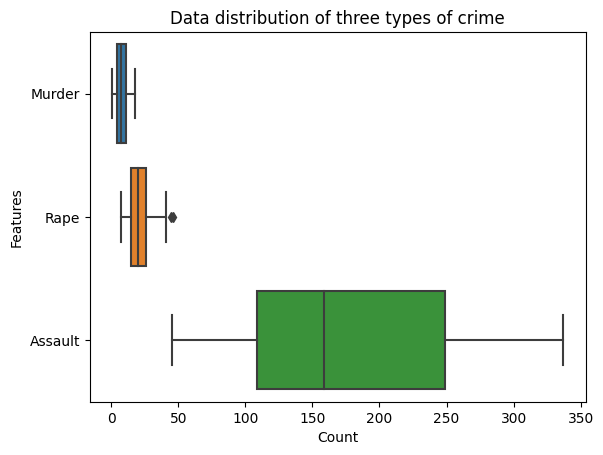

In [9]:
# look at the statistics of the three crimes on a boxplot
# urban pop has been left off as it was a percentage (I think) and not an absolute value

three_feat = df[['Murder','Rape', 'Assault']]
sns.boxplot(data= three_feat, orient = 'h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data distribution of three types of crime')


In [10]:
# scale dataframe using standard scaler

scaled = StandardScaler().fit_transform(df.iloc[:,1:5])
df_scale = pd.DataFrame(scaled, columns = df.columns[1:5])
df_scale.head()


,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


PCA ANALYSIS

In [11]:
# apply PCA analysis and then show how each component attributes itself to the explained variance

pca = PCA().fit(df_scale)

pca.explained_variance_ratio_


array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

It seems that murder then assault contribute to the explained variance the most. 

Text(2.8, 86, '85% threshold')

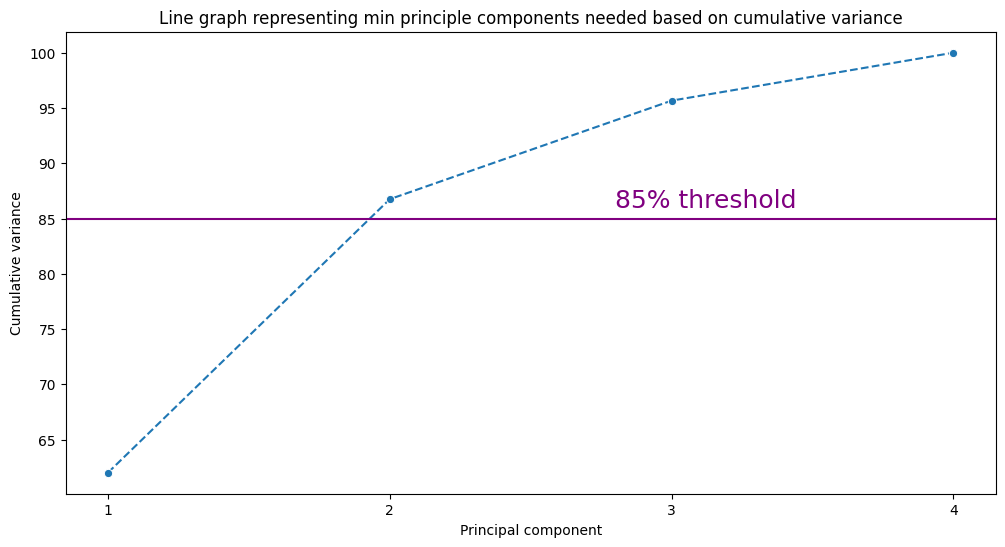

In [12]:
# create a graph to show the minimum number of components for analysis

X = np.arange(1,5, step =1)

plt.figure(figsize=(12,6))
sns.lineplot(x=X, y = np.cumsum(pca.explained_variance_ratio_)*100, linestyle = '--', 
    marker = 'o')
plt.title('Line graph representing min principle components needed based on cumulative variance')
plt.xlabel('Principal component')
plt.xticks(X)
plt.ylabel('Cumulative variance')
plt.axhline(y=85, color = 'purple', linestyle='-')
plt.text(2.8,86, '85% threshold', color ='purple', fontsize =18)


I will use 2 principal components as 2 is above the (arbitrary) 85% threshold.

In [52]:
# PCA with two components

pca = PCA(n_components =2)

PC = pca.fit_transform(df_scale)

PC.shape

(50, 2)

In [65]:
# transform to pandas df

PC_df = pd.DataFrame(data = PC, columns =['PC 1','PC 2'])
PC_df['State'] = df['State']

PC_df = PC_df.set_index('State')

PC_df.head()

,PC 1,PC 2
State,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


<AxesSubplot: title={'center': 'Variance explained by principal components'}, xlabel='Principal Component', ylabel='variance explained'>

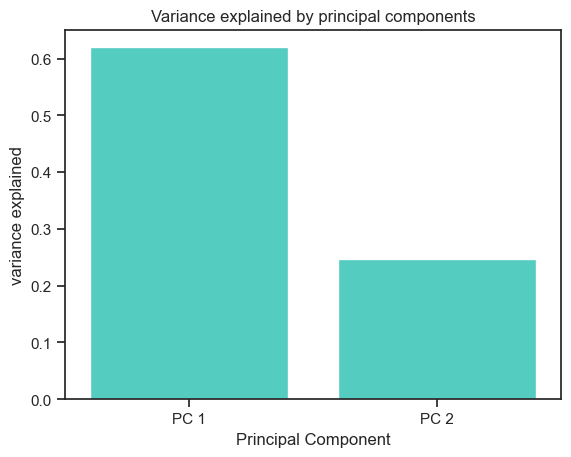

In [57]:
# create barplot to show PCA

df_2 = pd.DataFrame({'variance explained': pca.explained_variance_ratio_, 
    'Principal Component': ['PC 1','PC 2']})
plt.title('Variance explained by principal components')
sns.barplot(x = 'Principal Component', y = 'variance explained', data = df_2, 
    color = 'turquoise')

Variance is much higher for PC 1. 

In [60]:
# plot biplot of PCAs

x_new = PC
labels =arrest_corr.columns
states = PC_df.index


def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

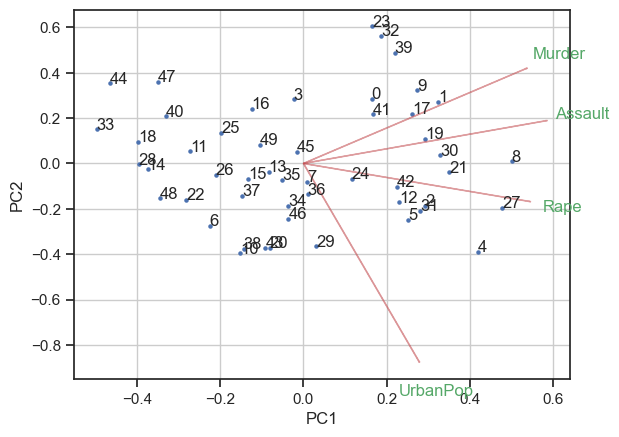

In [61]:
biplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

I think that this is telling me that
a) there are no negatively correlated variables since no vectors are opposite each other (i knew this already)
b) most components are represented similary in the two PCAs since the vector lengths are roughly equal
c) urban pop is less correlated with each crime than the crimes are with each other, but is slightly more correlated with rape than with murder/assault (info taken from the angles between vectors)

In [62]:
# check feature importance

pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Assault has the highest importance on PC1, but murder/rape are similar. 
UrbanPop has by far the highest importace on PC2. 

HIERARCHICAL CLUSTERING

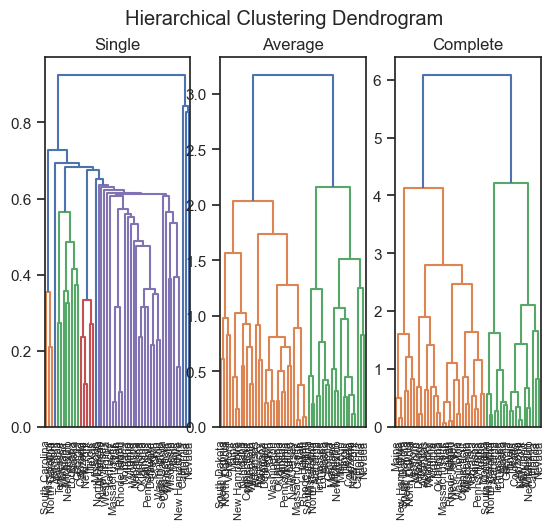

In [66]:
# perform heirarchical clustering on the PCA data

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(PC_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(PC_df, method='single'), labels=PC_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(PC_df, method='average'), labels=PC_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(PC_df, method='complete'), labels = PC_df.index, ax=ax3)
plt.show()

Single clustering seems a bit mental (!) whereas average and complete seem similar.

I will look at average more closely.

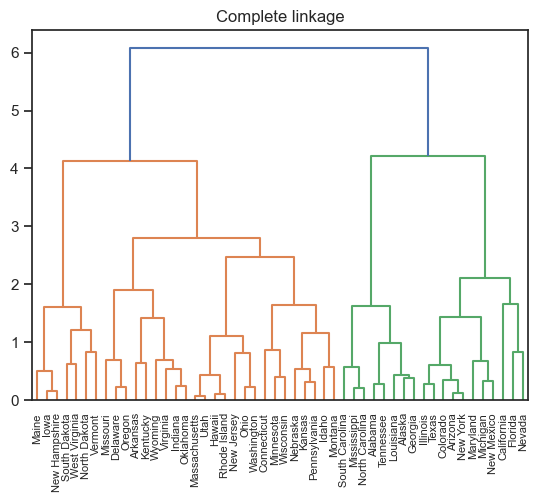

In [70]:
plt.title("Complete linkage")
dendrogram(linkage(PC_df, method='complete'), labels=PC_df.index)
plt.show()

There are two clusters, one is roughly 2/3 of sttes, and the other is 1/3 of states. 

I am unsure what the division between clusters could represent. It is possible that this question can only be answered using detailed socio-economic data about each state. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


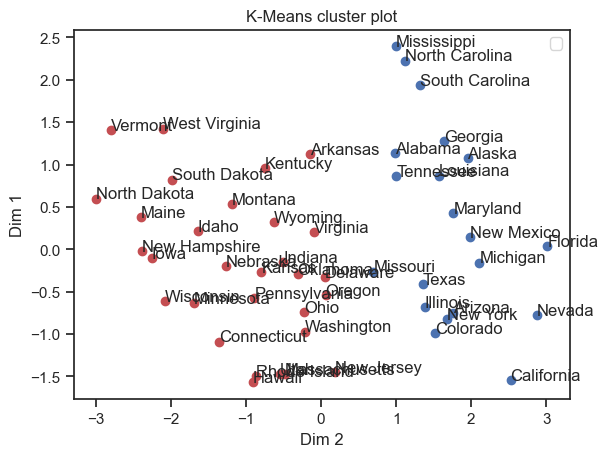

In [51]:
# Check K-means clustering of PCAs

# We extract the first two components
x = PC_df['PC 1']
y = PC_df['PC 2']

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(PC_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

I tried k=2 and k=3 for this plot. 

The heirarchical clustering suggested two groups, and I wondered if k=2 may somehow reflect the bipartisan politics of america, but I'm not sure if it does or not since my knowledge of how each state voted is not complete. 

KMEANS CLUSTERING

I also performed some k-means clustering on the actual data rather than using the PCAs, just to see whether it showed anything more concrete. 

In [21]:
# check if there are missing values
print(df.isnull().sum(), end='\n\n')

# check if there are non-numerical features
print(df.info())


State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB
None


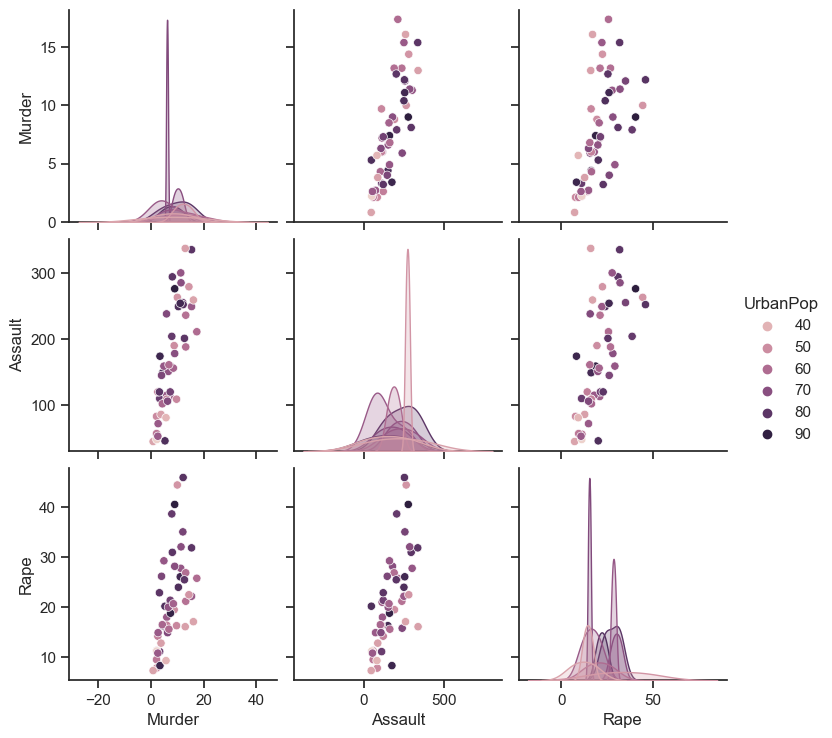

In [23]:
# plot to see correlations between features (have used heatmap already)
# Set hue as urban pop to see if that correlates with anything

sns.set_theme(style="ticks")
sns.pairplot(df, hue="UrbanPop")

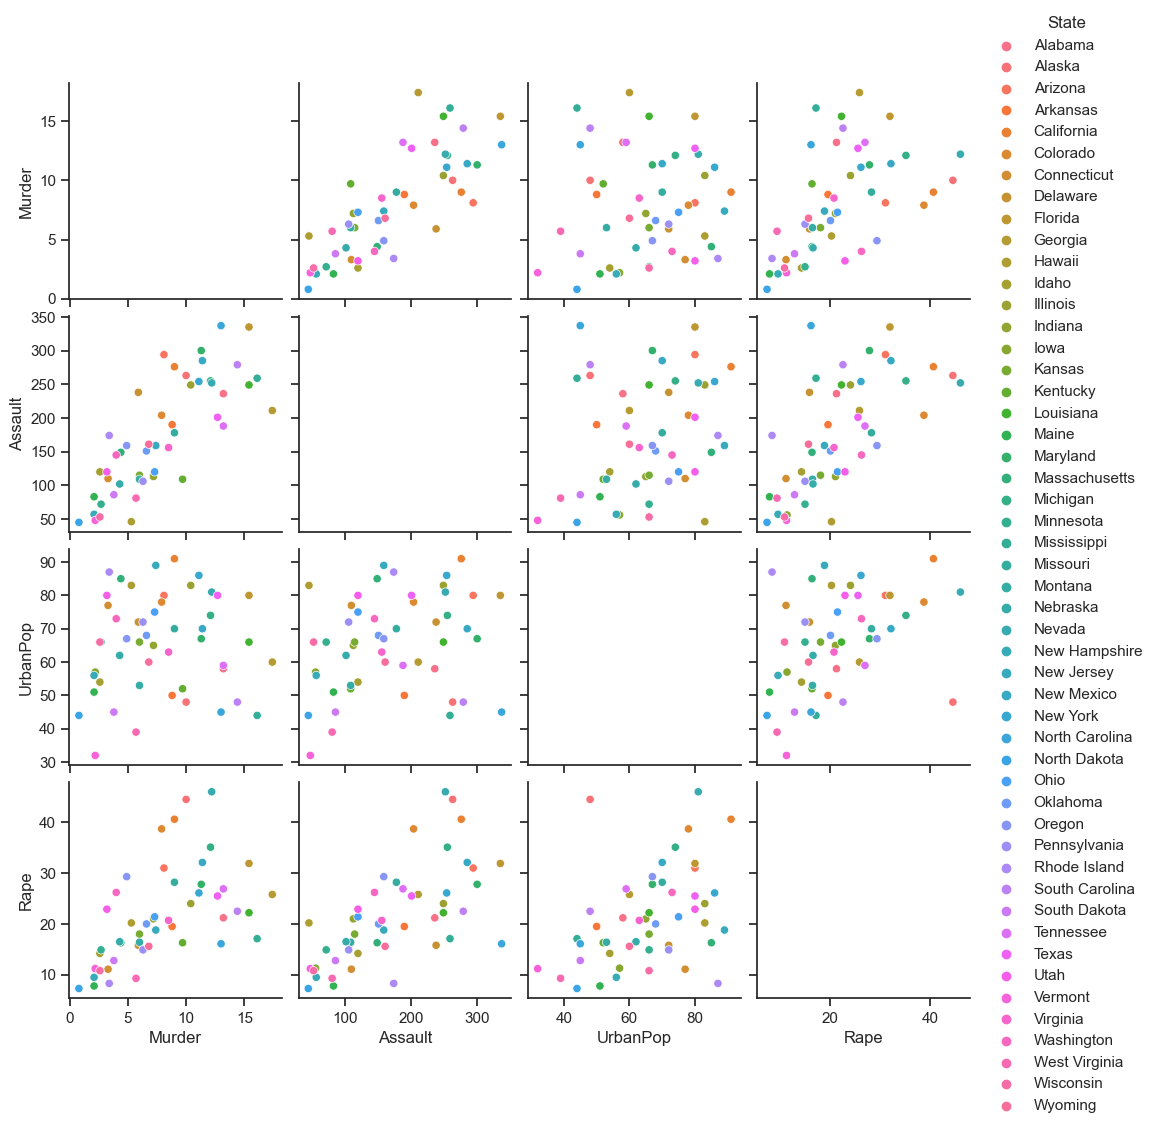

In [24]:
# plot heatplot to see correlations between features
# Set hue as state to see if that correlates with anything

sns.set_theme(style="ticks")
sns.pairplot(df, hue="State")

There don't appear to be any obvious groupings.

I will look closer at a couple of variables, just in case. 

In [35]:
# select urban pop and rape data

X = df[['UrbanPop','Rape']].values.reshape(-1,2)  

print('Data size:')
print(X.shape)

Data size:
(50, 2)


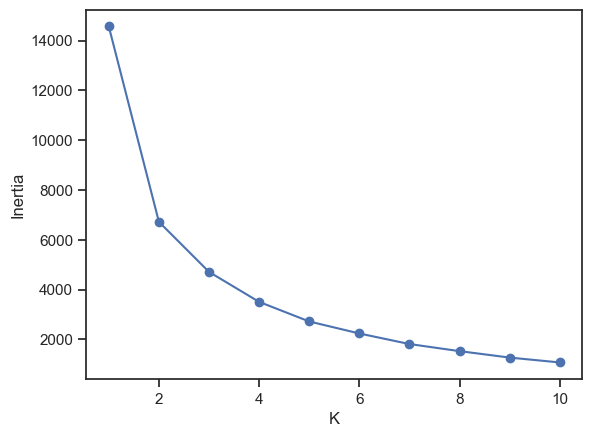

In [36]:
# Use elbow method to double check what k should be

def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)

It looks like K should be 2. 

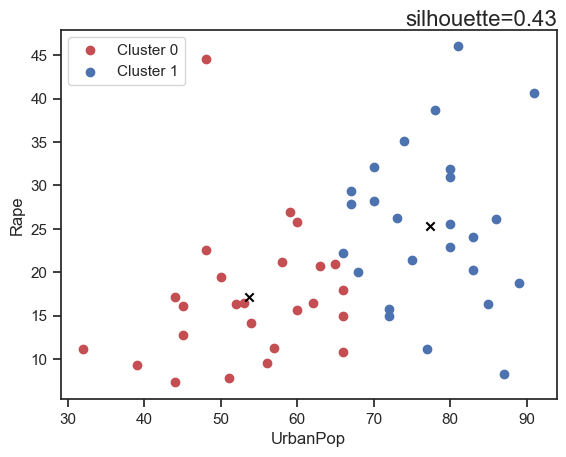

In [37]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('UrbanPop')
    plt.ylabel('Rape')
    plt.legend()
    plt.show()

for k in range(2,3):
  scatter_Kmeans(X, k, r=0)

The silhouette score for this model is 0.43, which is low. 

Although there could be two groups in the data, but there is not enough information in the dataset to figure out what they represent. In fact, I would go so far as to say that these clusters are meaningless (?). There is not an obvious correlation between rape and urban population. In areas of low urban population, there are fewer arrests for rape. In areas of high urban population, there may or may not be high numbers of arrests for rapes. 

Since these statistics represent arrests, and rape arrests do not represent the actual numbers of rapes committed , I am not sure that any meaningful conclusions can be drawn. 


In [38]:
# check the highest correlation on the heatmap: murder and assault

X = df[['Murder','Assault']].values.reshape(-1,2)  

print('Data size:')
print(X.shape)

Data size:
(50, 2)


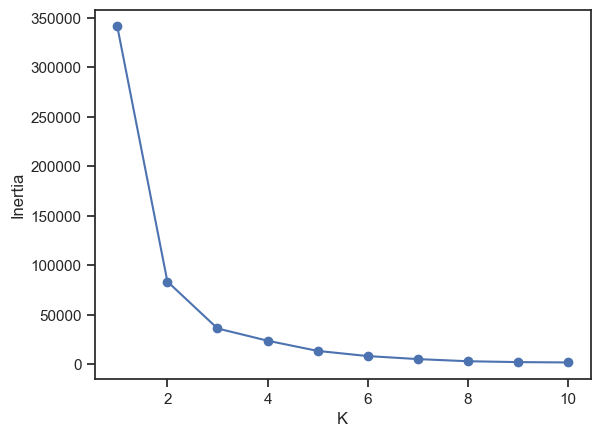

In [39]:
# Use elbow method to double check what k should be

def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)

It looks like k should be 2 or 3. I will test both and see which gives the highest silhouette score. 

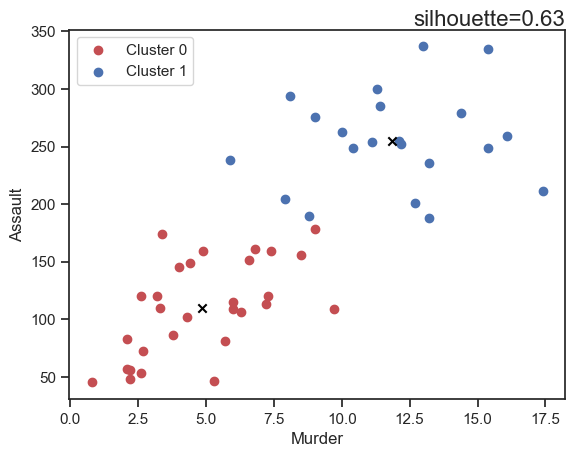

In [71]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Murder')
    plt.ylabel('Assault')
    plt.legend()
    plt.show()

for k in range(2,3):
  scatter_Kmeans(X, k, r=0)

The silhouette score is higher for this model (k=2, 0.63) but again, I'm not sure that this gives us any meaningful data. 

There is more clearly a correlation between murder and assault: the higher the murder arrests, the higher the assualt arrests. 

Since urban population does not correlate highly with either murder or results, it is unlikely that these clusters could reflect urban population. They could, instead, be indicative of things like state laws or state police regulations (e.g. is assault classified differently in each state? do police need to obtain higher arrest numbers in certain states?). 